# Skin Diagnostic Tracker

Abstract:

People with skin diseases face challenges daily, they meet up with their dermatologist bi-weekly or on a monthly basis, but many patients get reactions to their skin on a daily basis, such as after eating certain foods, or after applying a new ointment. Sometimes people don't have a skin disease but spot a mark on their body and are curious to know what it is, but afraid or lazy to contact a dermatologist. As a result I am made this mobile application called: Skin Diagnostic Tracker, where individuals can take pics of their skin and it will give you preliminary diagnosis of the skin condition you have, for example Psoriasis, or Varicose Veins, and etc. Now additionally, you can add captions, for example, Psoriasis got worse after eating onions, or after mental breakdown, or etc. The image result and captioning gets sent to a RAG Agent which is a gnerative AI, which will automatically provide recommendations for self-care. It's customized as it has your EHR attached. With that additional feature, you can quickly query your latest blood report results, or any other data, and due to it's LLM power it can give u high level explaination, rather than opening up and scrolling to find it.All conversations and photos, get logged into app. The idea isn't to replace a doctor and it won't, bi-weekly it prompts the user to send the report to his/her dermo, who can use that information to better guide you in your treatment plan, by introducing you to new more effective medicines, or new better dietary plans, and a general regular monitory check.

This app allows for more self-care and an active role in maintaining your health, and also getting a more suitable treatment plan as the constant communication is conveyed to your dermatologist.

#### I: PART ONE: ResNet
Load Data
Preprocess Data
Split Data
Normalize Data

#### I: PART TWO: Model
Build CNN Model
Test Model

#### I: PART THREE: RAG
Build RAG

### Download and Import Necessary Dependencies

In [7]:
%pip install matplotlib pandas tensorflow numpy scikit-learn


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: /usr/local/Cellar/jupyterlab/4.2.1/libexec/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [8]:
# These various packages allow me to read the image, plot the image, allow me to manipulate it, and combine it into one big folder

import os
import shutil
import numpy as np
import pandas as pd
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt

### Combine Both Folders of Data Into One

In [9]:
# This first path loads the directories and returns my images as a list in one big directory

# the source and destination folder paths
filepath1 = '/Users/rathangpandit/Desktop/SkinDiagnosticTracker/HAM10000_images_part_1'
filepath2 = '/Users/rathangpandit/Desktop/SkinDiagnosticTracker/HAM10000_images_part_2'
data = '/Users/rathangpandit/Desktop/SkinDiagnosticTracker/data'

# creates the destination folder
if not os.path.exists(data):
    os.makedirs(data)


# list of files in folder one
filenames1 = os.listdir(filepath1)
filenames2 = os.listdir(filepath2)

for file in range(len(filenames1)):
    filepath = os.path.join(filepath1,filenames1[file])    
    shutil.move(filepath, os.path.join(data, filenames1[file]))

for file in range(len(filenames2)):
    filepath = os.path.join(filepath2,filenames2[file])    
    shutil.move(filepath, os.path.join(data, filenames2[file]))
    

# So as you can see now the data directory has 10,015 images a combination of both files 5k and 5015.
numberOfFiles = os.listdir(data)
print("The size of the folder right now is: " + str(len(numberOfFiles)))


The size of the folder right now is: 8


In [10]:
# here lets try and print the size of one of these images

# firstFile = numberOfFiles[0]
# print("File Name: " + firstFile)

# print("File Image: ")
# image = Image.open(data + '/' + firstFile)
# plt.imshow(image)
# plt.show()
# plt.axis('off')

### Preprocessing the Data

In [11]:
# Now that we have the dataset loaded and we can print the images, we want to preprocess the data
# 1) let's make all the images sizes the same -> all are between 100 and 400 kb, so we we aren't going to remove any images
# 2) using SkLearn let's resize all the images to be the same (another note, we don't have to worry about the extension, all are jpg)
# 3) Let's normalize the dataset to be between 0-1 instead of the RBG 255 
######### We are going to do the size creation and batch creation and all the other basic processing through the keras utility and for that I 
# just realized, I will need the metadata of the classes, so that I can create subfolders, as it keras needs the images to be orgnaized in 
# that manner.

import os
import pandas as pd
import tensorflow as tf
import numpy as np

df = pd.read_csv('HAM10000_metadata.csv')
skinConditions = df['dx'].unique()

base_path = '/Users/rathangpandit/Desktop/SkinDiagnosticTracker/data'

for condition in skinConditions:
    condition_path = os.path.join(base_path, condition)
    if not os.path.exists(condition_path):
        os.makedirs(condition_path)

dataPath = os.listdir(base_path)

for file in dataPath:
    if file.endswith('.jpg'): 
        image_id = file.split('.')[0]
        
        
        imageValues = df[df['image_id'] == image_id]
        
       
        if imageValues.empty:
            continue
        
        dxVal = imageValues['dx'].values[0]
        
        filepath = os.path.join(base_path, file)
        target_dir = os.path.join(base_path, dxVal)
        

        shutil.move(filepath, os.path.join(target_dir, file))
        print(f"Moved {file} to {target_dir}")


#tf.keras.utils.image_dataset_from_directory??
#print("Hello")
print(tf.__version__)

data = tf.keras.utils.image_dataset_from_directory('data')
data_iterator = data.as_numpy_iterator() # we can't just access data without converting to numpy
batch = data_iterator.next()

2.16.2
Found 10015 files belonging to 7 classes.


### Normalize the data 0-1

In [12]:
# This prints our batch shape, batch size is 32, size of image is 256 by 256 and 3 is rbg
data = tf.keras.utils.image_dataset_from_directory('data')
data = data.map(lambda x, y: (x/255,y))
scaled_iterator = data. as_numpy_iterator()
batch = scaled_iterator.next()
batch[0].max()

Found 10015 files belonging to 7 classes.


1.0

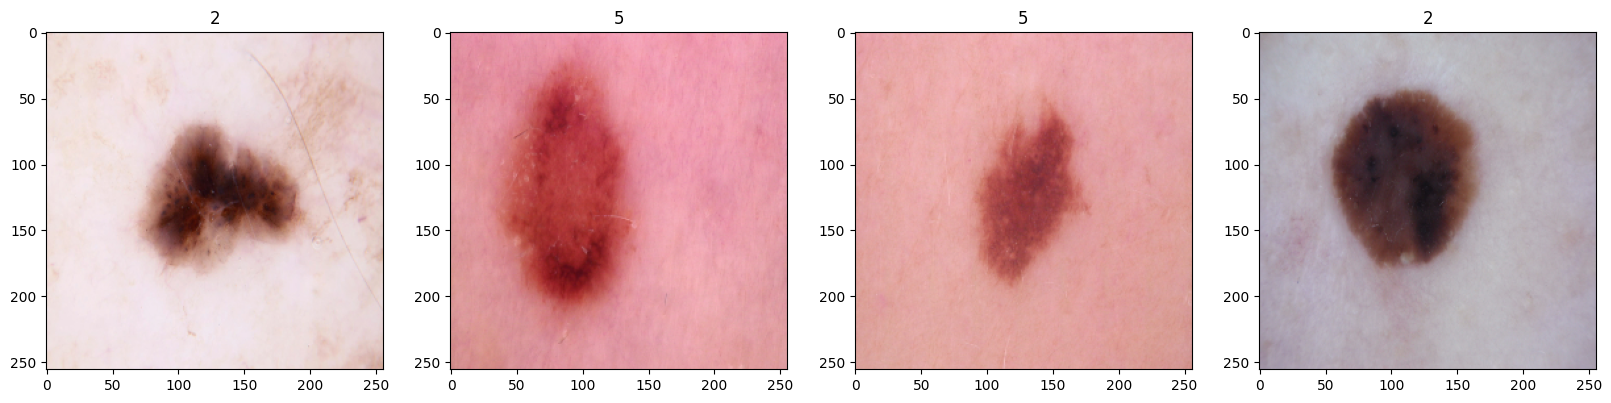

In [13]:
fig, ax = plt.subplots(ncols = 4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img) ## can't be astype int as it would just be 0 and 1
    ax[idx].title.set_text(batch[1][idx])

### Split the Data

In [14]:
# Was initially going to use Sklearn but realized i don't have to the label and image array
    # so we won't have individual image access like in X_train and Y_test since we are working with batches
    # also going to add a validation partiion as It's good practice to evaluate performance 
len(data) # 313 should be the number of batches: 10015/32 approx = 313
train_size = int(len(data)*.7)
test_size = int(len(data)*.2)+1   # since the math won't round it to 313
validation_size = int(len(data)*.1)

In [15]:
# take is how much data in batch size we take
# skip is going to skip the intial batch size -> this is useful when we want to get the next set of batches of data
train_data = data.take(train_size)
test_data = data.skip(train_size).take(test_size)
validation_data = data.skip(train_size+test_size).take(validation_size)

In [16]:
len(validation_data)

31

### Building the CNN Model

In [76]:
# from tensorflow.keras import layers, models

# cnn = models.Sequential([
#     layers.Input(shape=(256, 256, 3)),
#     layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),
    
#     layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),
#     layers.BatchNormalization(),

#     layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),
#     layers.BatchNormalization(),
    
#     layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),
    
#     layers.Flatten(),
#     layers.Dense(256, activation='relu'),
#     layers.Dense(7, activation='softmax')
# ])


# cnn = models.Sequential([
#     layers.Input(shape=(256, 256, 3)),
#     layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),
    
#     layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),

#     layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),

#     layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),
#     layers.BatchNormalization(),

#     layers.Flatten(),
#     layers.Dense(512, activation='relu'),
#     layers.Dropout(0.5),
#     layers.Dense(7, activation='softmax')
# ])


# cnn = models.Sequential([
#     layers.Input(shape=(256, 256, 3)),
    
#     layers.Conv2D(64, (3, 3), activation='relu'),
#     layers.BatchNormalization(),
#     layers.MaxPooling2D((2, 2)),
    
#     layers.Conv2D(128, (3, 3), activation='relu'),
#     layers.BatchNormalization(),
#     layers.MaxPooling2D((2, 2)),
    
#     layers.Conv2D(128, (3, 3), activation='relu'),
#     layers.BatchNormalization(),
#     layers.MaxPooling2D((2, 2)),
    
#     layers.Conv2D(256, (3, 3), activation='relu'),
#     layers.BatchNormalization(),
#     layers.MaxPooling2D((2, 2)),
    
#     layers.Conv2D(512, (3, 3), activation='relu'),
#     layers.BatchNormalization(),
#     layers.MaxPooling2D((2, 2)),
    
#     layers.Flatten(),
#     layers.Dense(512, activation='relu'),
#     layers.BatchNormalization(),
#     layers.Dropout(0.5),
#     layers.Dense(7, activation='softmax')
#])


# from tensorflow.keras.applications import VGG16

# base_model = VGG16(input_shape=(256, 256, 3), include_top=False, weights="imagenet")
# base_model.trainable = False  # Freeze the base model layers

# model = models.Sequential([
#     base_model,
#     layers.Flatten(),
#     layers.Dense(512, activation='relu'),
#     layers.Dropout(0.5),
#     layers.Dense(7, activation='softmax')
# ])


# from tensorflow.keras.layers import Flatten, BatchNormalization, Dropout, Dense


# from tensorflow.keras.applications import ResNet50
# from tensorflow.keras import layers, models
# from tensorflow.keras.optimizers import Adam

# # Load pre-trained ResNet50 model without the top layer
# base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# # Freeze base model layers
# base_model.trainable = False

# # Build a new model on top
# model = models.Sequential()
# model.add(base_model)
# model.add(Flatten())
# model.add(BatchNormalization())
# model.add(Dense(128, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.5))
# model.add(Dense(7, activation='softmax'))


from tensorflow.keras.applications import MobileNetV2  # Import MobileNetV2

img_shape = (256, 256, 3) 

# Initialize MobileNetV2
classifier = MobileNetV2(
    include_top=False,  # Exclude the top classification layer
    input_shape=img_shape,  # Input shape of your images
    weights='imagenet'  # Use pretrained weights
)

# Fine-tune specific layers
fine_tune_at = 100 
for layer in classifier.layers[:fine_tune_at]:
    layer.trainable = False


# Add classifier layers on top of MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, BatchNormalization, Dense, Dropout

model = Sequential()
model.add(classifier)
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(7, activation='softmax'))  # Assuming 7 classes in your dataset


# Import necessary libraries
# from tensorflow.keras.applications import EfficientNetB0
# from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
# from tensorflow.keras.models import Model
# from tensorflow.keras.callbacks import EarlyStopping

# # Load EfficientNetB0 as the base model
# base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
# base_model.trainable = False  # Freeze the base model for transfer learning

# # Build the model
# x = base_model.output
# x = GlobalAveragePooling2D()(x)
# x = Dense(256, activation='relu')(x)
# predictions = Dense(7, activation='softmax')(x) 
# model = Model(inputs=base_model.input, outputs=predictions)

# # Compile the model
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# # Set early stopping to prevent overfitting
# early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)



/var/folders/fp/f6n4kkj56f5gb82wdz2w92cc0000gn/T/ipykernel_39885/667129316.py:121: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  classifier = MobileNetV2(


In [77]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 8, 8, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 81920)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 81920)          │       327,680 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 128)            │    10,485,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,072,967 (49.87 MB)

 Trainable params: 12,512,327 (47.73 MB)

 Non-trainable params: 560,640 (2.14 MB)

### First Run in Fitting 

Looking at a particular tutorial online, I am also going to create a logs file so we can see performance and make changes based on it,
because I am not sure, if on the first try our model is going to be super accurate. 


First Attempt: 77% 
Second Attempt: 64% -> reduced epochs to 5, neural layers, and added batch normalization in-between a few layers 
Third Attempt: 70% -> 20 epochs, batch normalization, 
Fourth Attempt: 65%
Fifth Attempt: 75%

In [78]:
from tensorflow.keras.callbacks import EarlyStopping
# logsDir = 'logs'
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logsDir)
# hist = cnn.fit(train_data, epochs=20, validation_data=validation_data, callbacks=[tensorboard_callback])



logsDir = 'logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logsDir)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
hist = model.fit(train_data, epochs=20, validation_data=validation_data,
               callbacks=[tensorboard_callback, early_stopping])

Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 360s 2s/step - accuracy: 0.5878 - loss: 1.7187 - val_accuracy: 0.0959 - val_loss: 16.2841
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 344s 2s/step - accuracy: 0.7265 - loss: 0.9325 - val_accuracy: 0.0252 - val_loss: 18.1551
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 354s 2s/step - accuracy: 0.7766 - loss: 0.7036 - val_accuracy: 0.0747 - val_loss: 7.1586
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 408s 2s/step - accuracy: 0.8206 - loss: 0.5642 - val_accuracy: 0.4511 - val_loss: 3.5777
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 365s 2s/step - accuracy: 0.8641 - loss: 0.4256 - val_accuracy: 0.7154 - val_loss: 1.2959
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 395s 2s/step - accuracy: 0.8826 - loss: 0.3673 - val_accuracy: 0.7588 - val_loss: 1.2190
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 383s 2s/step - accuracy: 0.9043 - loss: 0.2868 - val_accuracy: 0.5721 - val_loss: 2.2958
Epoch 8/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 451s 2s/step - accuracy: 0.9122 - loss: 0.2716 - val_ac

In [79]:
model.evaluate(test_data)

63/63 ━━━━━━━━━━━━━━━━━━━━ 60s 781ms/step - accuracy: 0.7518 - loss: 1.1311


[1.1860936880111694, 0.7420634627342224]

In [81]:
from tensorflow.keras. models import load_model
model.save(os.path.join('models','h5SkinDiagnosticFile.h5'))

In [10]:
import os

h5_file_path = "/Users/rathangpandit/Desktop/SkinDiagnosticTracker/models/h5SkinDiagnosticFile.h5"

if not os.path.exists(h5_file_path):
    raise FileNotFoundError(f"File not found at {h5_file_path}. Check the path and try again.")

In [4]:
%pip install coremltools
%pip install tf2onnx

Note: you may need to restart the kernel to use updated packages.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.7/16.7 MB 4.8 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.5
    Uninstalling protobuf-4.25.5:
      Successfully uninstalled protobuf-4.25.5
Note: you may need to restart the kernel to use updated packages.


In [7]:
import tensorflow as tf

# Load your Sequential model
keras_model = tf.keras.models.load_model("/Users/rathangpandit/Desktop/SkinDiagnosticTracker/models/h5SkinDiagnosticFile.h5")

# Wrap the Sequential model in a Functional model to provide clear inputs/outputs
input_layer = tf.keras.Input(shape=keras_model.input_shape[1:])
output_layer = keras_model(input_layer)
functional_model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

import tf2onnx

# Specify the ONNX model path
onnx_model_path = "model.onnx"

# Define the input signature
spec = (tf.TensorSpec(functional_model.input_shape, tf.float32, name="input"),)

# Convert the model
model_proto, _ = tf2onnx.convert.from_keras(functional_model, input_signature=spec, opset=13)

# Save the ONNX model
with open(onnx_model_path, "wb") as f:
    f.write(model_proto.SerializeToString())
print(f"Model successfully converted and saved to {onnx_model_path}")


2024-11-17 17:31:07.649340: I tensorflow/core/grappler/devices.cc:75] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
2024-11-17 17:31:10.614729: I tensorflow/core/grappler/devices.cc:75] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)


Model successfully converted and saved to model.onnx


In [14]:
%pip install coremltools==5.1
%pip install onnx-coreml

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.1/926.1 kB 8.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [6 lines of output]
      Traceback (most recent call last):
        File "<string>", line 2, in <module>
        File "<pip-setuptools-caller>", line 34, in <module>
        File "/private/var/folders/fp/f6n4kkj56f5gb82wdz2w92cc0000gn/T/pip-install-_gq0708u/coremltools_b001c59add5e41928784c3d658ba69ad/setup.py", line 8, in <module>
          import imp
      ModuleNotFoundError: No module named 'imp'
      [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
Note: you may need to restart

In [2]:
# import tensorflow as tf

# # Load your trained model
# model = tf.keras.models.load_model('/Users/rathangpandit/Desktop/SkinDiagnosticTracker/models/h5SkinDiagnosticFile.h5')

# # Convert to TensorFlow Lite format
# converter = tf.lite.TFLiteConverter.from_keras_model(model)
# tflite_model = converter.convert()

# # Save the TensorFlow Lite model
# with open('model.tflite', 'wb') as f:
#     f.write(tflite_model)


In [3]:
%pip install flask

Note: you may need to restart the kernel to use updated packages.


### WE ARE GOING TO CREATE AN API IN THE MAIN.PY FILE